# Visual Representation of all NFDI4BIOIMAGE Training Materials

In this notebook, the contents of the [Training Materials](https://nfdi4bioimage.github.io/training/readme.html) are displayed using a UMAP. 

Each data type (e.g. presentation slides, website, git repository, ...) is displayed in a unique color to identify the overall structure and distribution of data types across the different topics covered by the Training Material.

In [1]:
import sys
import os

# Add the scripts directory to Python path to import functions
sys.path.append(os.path.abspath("../scripts"))

In [2]:
import pandas as pd
from generate_link_lists import load_dataframe

# This file exports selected data as csv file
source = "../resources/"

df = load_dataframe(source)
df.head()

,authors,name,proficiency_level,tags,type,url,license,event_date,event_location,description,num_downloads,publication_date,fingerprint,author,submission_date
0,[Elisabeth Kugler],Sharing Your Poster on Figshare: A Community G...,novice,"[Sharing, Research Data Management]",[Blog Post],https://focalplane.biologists.com/2023/07/26/s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[Marcelo Zoccoler],Running Deep-Learning Scripts in the BiA-PoL O...,proficient,"[Python, Artificial Intelligence, Bioimage Ana...",[Blog Post],https://biapol.github.io/blog/marcelo_zoccoler...,CC-BY-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[Robert Haase],Browsing the Open Microscopy Image Data Resour...,competent,"[OMERO, Python]",[Blog Post],https://biapol.github.io/blog/robert_haase/bro...,CC-BY-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[Mara Lampert],Getting started with Mambaforge and Python,novice,"[Python, Conda, Mamba]",[Blog Post],https://biapol.github.io/blog/mara_lampert/get...,CC-BY-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[Jennifer Waters],Promoting Data Management at the Nikon Imaging...,novice,[Research Data Management],[Blog Post],https://datamanagement.hms.harvard.edu/news/pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
from itertools import chain

# extract all unique data types
all_types = df['type'].dropna().tolist()
flat_list = list(chain.from_iterable(t if isinstance(t, list) else [t] for t in all_types))
unique_types = list(set(flat_list))
unique_types

['Notebook',
 'YouTube Channel',
 'Forum Post',
 'Publication',
 'Workflow',
 'Presentation',
 'Workshop',
 'Online Tutorial',
 'Event',
 'Poster',
 'Worksheet',
 'Book',
 'Webinar',
 'Conference Abstract',
 'collection',
 'Blog Post',
 'Tutorial',
 'notebook',
 'Video',
 'Data',
 'Website',
 'Atlas',
 'Collection',
 'Software',
 'GitHub Repository',
 'Slides',
 'Wiki',
 'publication',
 'Code',
 'Framework',
 'Document',
 'Online Course',
 'GitLab Repository',
 'Documentation',
 'Github repository',
 'Tool',
 'Report',
 'notebooks',
 'Blog post',
 'Preprint',
 'Application',
 'Github Repository']

### Plot the Distribution of all data types
To get an overview about all topics, it might be helpful to look at their distribution. 

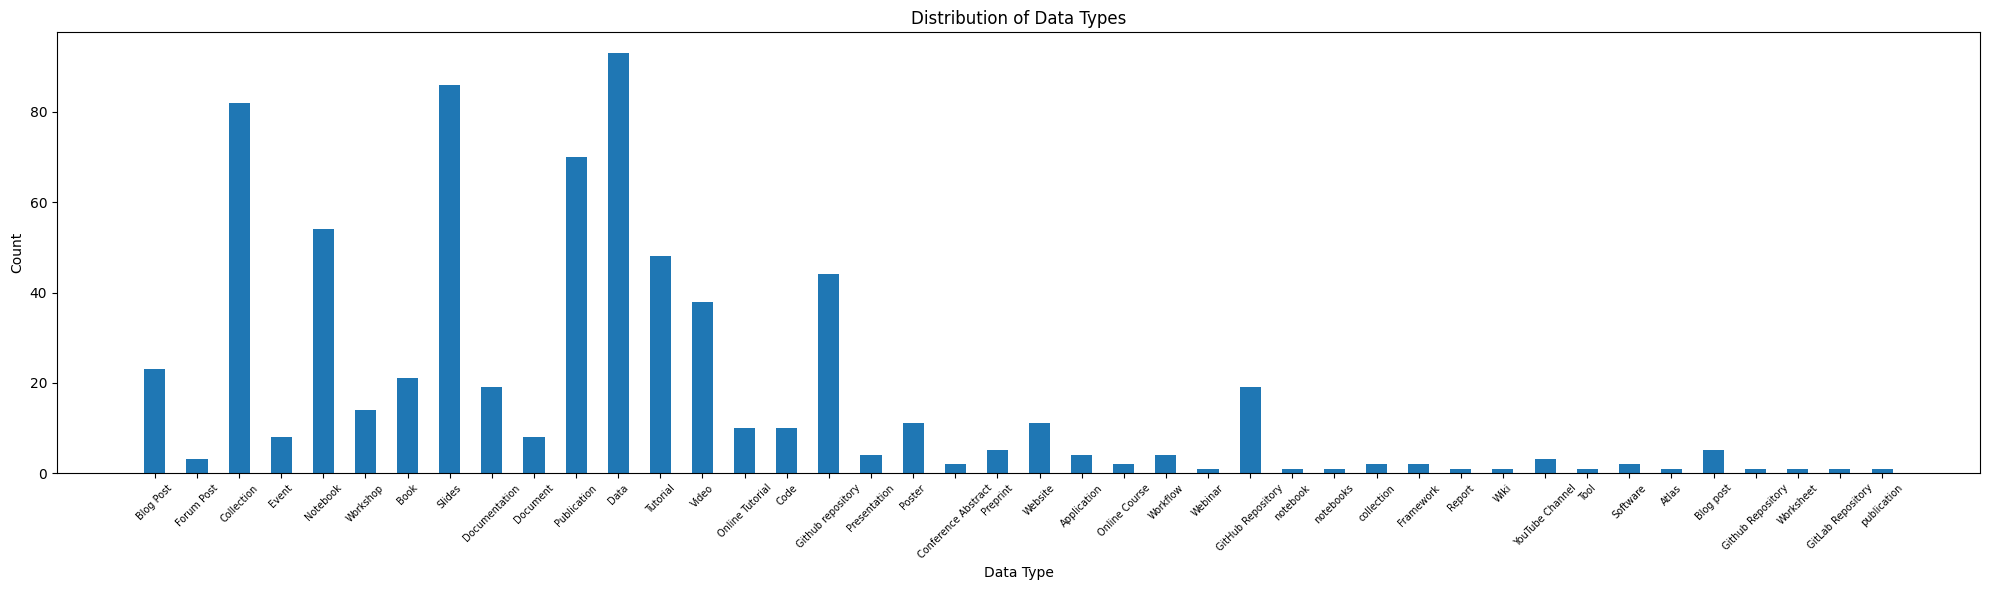

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

# Count frequency of each type
type_counts = Counter(flat_list)

# Create a bar chart
plt.figure(figsize=(20, 6))
plt.bar(type_counts.keys(), type_counts.values(), width=0.5)
plt.xlabel("Data Type")
plt.ylabel("Count")
plt.title("Distribution of Data Types")
plt.xticks(rotation=45, fontsize = 7)
plt.tight_layout()

plt.show()

# Goal is to generate an embedding of every entry that can be reduced and visualized in a 2D UMAP Space
To do this, it has to be clear which information from each content to use for the embedding generation. For this, several columns are checked regarding their consistency.
The best columns to choose are:
- Description
- URL (and its corresponding website)
- Tags

In [5]:
# Count how many entries are lists with more than one element
multi_type_count = df["type"].apply(lambda x: isinstance(x, list) and len(x) > 1).sum()

print(f"Entries with multiple data types: {multi_type_count}")

Entries with multiple data types: 130


**Problem:**

There are several entries, that have more than one data type. As the goal is to see which topics still lack in specific data types, those entries will get split into "multiple" entries, each with onre of the data types they are listed as.

In [6]:
# Ensure all type values are lists
df["type"] = df["type"].apply(lambda x: x if isinstance(x, list) else [x])

# Explode the DataFrame by type
df_exploded = df.explode("type").rename(columns={"type": "single_type"}).reset_index(drop=True)

In [7]:
# Total number of entries
len(df_exploded)

919

# 1. Use description for the Embedding calculation

In [8]:
# Total number of entries with a proper description
len(df_exploded['description'].dropna())

629

About 300 entries don't have a proper description. That makes it hard to cluster them based on their embedded text description. Still, description might be the best textual information to group entries by content.

In [9]:
def embed_text(text):
    if isinstance(text, str) and text.strip().lower() != "failed":
        return model.encode(text)
    return None

In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B")

# Another good option would be this model:
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

ModuleNotFoundError: No module named 'sentence_transformers'

In [ ]:
# Replace the NaN values with a string for better clarity in the plot
df_exploded["description"] = df_exploded["description"].fillna("no description")

# Compute Embedding
df_exploded["description_embedding"]= df_exploded["description"].apply(embed_text)

In [ ]:
from umap import UMAP
import numpy as np

# Create UMAP instance
umap_model = UMAP(n_components=2, random_state=42)

# Apply UMAP
X = np.vstack(df_exploded["description_embedding"].values)
description_embedding_2d = umap_model.fit_transform(X)

In [ ]:
# store it
df_exploded["description_umap_x"] = description_embedding_2d[:, 0]
df_exploded["description_umap_y"] = description_embedding_2d[:, 1]

In [ ]:
import plotly.express as px

fig = px.scatter(
    df_exploded,
    x="description_umap_x",
    y="description_umap_y",
    color="single_type",
    hover_data=["name", "url", "description"], 
    title="UMAP of Description Embeddings"
)

fig.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a color map for the types
unique_types_list = df_exploded['single_type'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_types_list))
color_map = {ttype: colors(i) for i, ttype in enumerate(unique_types_list)}

# Create the plot
plt.figure(figsize=(12, 10))
for ttype in unique_types_list:
    subset = df_exploded[df_exploded['single_type'] == ttype]
    plt.scatter(subset['description_umap_x'], subset['description_umap_y'], label=ttype, color=color_map[ttype], alpha=0.7)

plt.title('UMAP of Description Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Single Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### _RESULT:_

We can see two distinct clusters, those entries WITH and those WITHOUT a valid description:

- valid description clusters on the left
  -> e.g. cluster of Data as data type (red dots) at around x,y = (-1, 8)
- "no description" cloud on the top-right
  -> here, entries are packed quite tightly and are normally distributed

# 2. Use Title for the Embedding calculation


In [ ]:
# Total number of entries with a proper title
len(df_exploded['name'].dropna())

In [ ]:
# Compute Embedding
df_exploded["title_embedding"]= df_exploded["name"].apply(embed_text)

In [ ]:
# Apply UMAP
X = np.vstack(df_exploded["title_embedding"].values)
title_embedding_2d = umap_model.fit_transform(X)

In [ ]:
# store it
df_exploded["title_umap_x"] = title_embedding_2d[:, 0]
df_exploded["title_umap_y"] = title_embedding_2d[:, 1]

In [ ]:
fig = px.scatter(
    df_exploded,
    x="title_umap_x",
    y="title_umap_y",
    color="single_type",
    hover_data=["name", "url"], 
    title="UMAP of Title Embeddings"
)

fig.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a color map for the types
unique_types_list = df_exploded['single_type'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_types_list))
color_map = {ttype: colors(i) for i, ttype in enumerate(unique_types_list)}

# Create the plot
plt.figure(figsize=(12, 10))
for ttype in unique_types_list:
    subset = df_exploded[df_exploded['single_type'] == ttype]
    plt.scatter(subset['title_umap_x'], subset['title_umap_y'], label=ttype, color=color_map[ttype], alpha=0.7)

plt.title('UMAP of Title Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Single Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### _RESULT:_
Embeddings are mostly well distributed. But there are some thematically structured clusters, e.g.
- NFDI4Bioimage Cluster on the left around x,y = (-4, 9)
- Image Processing Cluster on the top right around x,y = (5, 11)
- StarDist Datasets at around x,y = (1, 13)

# 3. Use Tags for Embedding calculation

In [ ]:
print(f"Length of Dataset with each entry might be split into several single entries for each data type: {len(df_exploded)}")

print(f"Number of entries from that Dataset that have a valid Tag Column: {len(df_exploded['tags'].dropna())}")

There are a lot of entries missing a tag, so it is not clear whether this approach is well suited, because a lot of information will be missing. But still more entries can be used here in comparison to the description column.

In [ ]:
# Explode the DataFrame by Tags to have clusters that refer to single Tags instead of Tag-Groups
df_exploded_tags = df_exploded.explode("tags").rename(columns={"tags": "single_tag"}).reset_index(drop=True)

In [ ]:
# Total number of entries now
len(df_exploded_tags)

In [ ]:
# Replace the NaN values with a string for better clarity and clear clustering in the plot
df_exploded_tags["tag_final"] = df_exploded_tags["single_tag"].fillna("no tags")

df_exploded_tags["tag_embedding"]= df_exploded_tags["tag_final"].apply(embed_text)

### Calaculate UMAP of the Tag Embedding

In [ ]:
X = np.vstack(df_exploded_tags["tag_embedding"].values)
tag_embedding_2d = umap_model.fit_transform(X)

In [ ]:
df_exploded_tags["tag_umap_x"] = tag_embedding_2d[:, 0]
df_exploded_tags["tag_umap_y"] = tag_embedding_2d[:, 1]

In [ ]:
import plotly.express as px

fig = px.scatter(
    df_exploded_tags,
    x="tag_umap_x",
    y="tag_umap_y",
    color="single_type",
    hover_data=["name", "url", "single_tag"], 
    title="UMAP of Tag Embeddings"
)

fig.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a color map for the types
unique_types_list = df_exploded_tags['single_type'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_types_list))
color_map = {ttype: colors(i) for i, ttype in enumerate(unique_types_list)}

# Create the plot
plt.figure(figsize=(12, 10))
for ttype in unique_types_list:
    subset = df_exploded_tags[df_exploded_tags['single_type'] == ttype]
    plt.scatter(subset['tag_umap_x'], subset['tag_umap_y'], label=ttype, color=color_map[ttype], alpha=0.7)

plt.title('UMAP of Tag Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Single Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### _RESULT:_
In this plot, we can clearly spot the "to tags" cluster at around (11, 25). All other entries are very well separated regarding to their Tags. We can also see some clusters of Tags, that are dominated by one data type, e.g. 
- "AI-ready"-Tag cluster that only inherits Data as Data Type around x,y = (-9, 15)

By filtering data types to see only Blog-Post and then add more Data Types, we can reveal Tags that are still missing some useful Blog-Posts e.g.
- "GPU / Big Data" Cluster (20, -3)
- "Neubias" Cluster (21, 24)
- "ImageJ" Cluster (2, 20)
- "FAIR"-Principles (10, -8)